# Start from the input!

In [20]:
fed_path = input('Please enter the (absolute) file path of fed.csv:')
trade_path = input('Please enter the (absolute) file path of trade_war.csv:')


Please enter the (absolute) file path of fed.csv:/Users/amber/Desktop/Tools project/Fed events v3.csv
Please enter the (absolute) file path of trade_war.csv:/Users/amber/Desktop/Tools project/Trade disputes events v4.csv


In [11]:
# !pip install pandas-datareader
# !pip install fix_yahoo_finance
import pandas as pd
import datetime
from datetime import timedelta
import pandas_datareader.data as web
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
class EventStudy_Fed():
    def __init__(self,file_path):
        try:
            pd.read_csv(file_path)
        except TypeError:
            return f'Wrong File Type.'
        self.dataframe = pd.DataFrame(pd.read_csv(file_path))
        self.company = self.dataframe['Ticker']
        self.event = self.dataframe['Event']
        self.market = self.dataframe['Market']
        self.industry = self.dataframe['Industry']
        self.year = self.dataframe['Year']
        self.month = self.dataframe['Month']
        self.day = self.dataframe['Day']
        self.dict = {}
        self.reg_result = list()
        self.fed_cumu_ab_ret_per_event = list()
        self.fed_event_list = list()
        self.inds_level_AR = []
        self.indsdict = dict()

        for i in range(0,len(self.market)):
            self.dict[self.company[i]] = self.market[i]
        for i in range(0,len(self.industry)):
            self.indsdict[self.company[i]] = self.industry[i]
        eventdate = []
        for i in range(0,len(self.dataframe)):
            eventdate.append(datetime.datetime(self.year[i],self.month[i],self.day[i]))
        self.dataframe['EventDate'] = eventdate
        #suppose there is only one event in a month
        uniquedays = self.dataframe['EventDate'].unique()
        inter_days = []
        for i in range(0,len(uniquedays)-1):
            inter_days.append(int((uniquedays[i+1]-uniquedays[i])/np.timedelta64(1,'D')))
        self.sample_length = min(inter_days)
        self.fed_event_list = self.dataframe['Event'].unique()
    
    def reg(self):
        eventdate_set = self.dataframe['EventDate'].unique()
        subdate_cumulative_abnormal_return = pd.DataFrame()
        for date in eventdate_set:
            subevent_df = self.dataframe[self.dataframe.EventDate == date]
            start_date = date - np.timedelta64(self.sample_length, 'D')
            end_date = date + np.timedelta64(self.sample_length, 'D')
            subevent_company_list = subevent_df['Ticker'].unique()
            subevent_cumulative_abnormal_return = pd.DataFrame()
            
            for company in subevent_company_list:
                market = subevent_df[subevent_df.Ticker == company]['Market'].iloc[0]
                price = web.DataReader([company, market],'yahoo', start_date,end_date)
                close_price = price['Close']
                return_rate = close_price.pct_change()
                x = return_rate[company]    
                X = sm.add_constant(x)
                y = return_rate[market]
                model = sm.OLS(y,X,missing='drop')
                result = model.fit()
                (a,b) = result.params

                return_rate['Abnormal_Return'] = return_rate.apply(lambda x: x[market] - a - b * x[company], axis=1)
                subevent_cumulative_abnormal_return[f'{company}'] = return_rate['Abnormal_Return'].cumsum()[1:]
            company_name = list(subevent_cumulative_abnormal_return)
            industry_name = [self.indsdict[i] for i in company_name]
            trans_subevent_cumulative_abnormal_return =subevent_cumulative_abnormal_return.T
            trans_subevent_cumulative_abnormal_return['Industry'] = industry_name
            inds_level_AR = trans_subevent_cumulative_abnormal_return.groupby('Industry').sum()
            inds_level_AR = inds_level_AR.iloc[0:,-1]
            self.inds_level_AR.append(inds_level_AR)
            
            subevent_cumulative_abnormal_return['Average_CAR'] = subevent_cumulative_abnormal_return.apply(lambda x: x.sum()/(len(subevent_company_list)),axis = 1)
                               

            self.reg_result.append(subevent_cumulative_abnormal_return['Average_CAR'])
            self.fed_cumu_ab_ret_per_event.append(subevent_cumulative_abnormal_return['Average_CAR'][-1])
    def visualization(self):
        num_fed_events = len(self.dataframe['EventDate'].unique()) # 8
        num_us_stock = len(self.industry)/num_fed_events #30
        fed_event_list = list(self.event[[0 + x*(len(self.dataframe)-0)/num_fed_events for x in range(num_fed_events)]])
        us_industry_list = list(self.industry)[0:int(num_us_stock)] #30 with duplicates
        us_unique_industry_list = list(set(us_industry_list)) #12 distinct industries
        us_unique_industry_count = list(np.unique(us_industry_list, return_counts=True)[1]) # 12 numbers
        us_unique_industry_count_pct = [(x*100) / 30 for x in us_unique_industry_count]
        

        plt.bar(list(range(8)),self.fed_cumu_ab_ret_per_event, align='center')
        plt.xticks(list(range(8)), self.fed_event_list)
        plt.xticks(rotation=90)
        plt.title("Portfolio Cumulative Abnormal Return for 8 Fed Events")
        plt.ylabel('return %');
        plt.show()
        
        fig1, ax1 = plt.subplots()
        ax1.pie(us_unique_industry_count_pct, labels=us_unique_industry_list, autopct='%1.1f%%',
        shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()
        
        empty_inds = pd.DataFrame()
        for i in range(len(self.inds_level_AR)):
            empty_inds[f'{i}'] = self.inds_level_AR[i].values
        z=empty_inds.T
        color = ['0.1','0.4','0.6','0.2','0.5','0.3','0.79','0.8','0.9']
        x = [i for i in range(len(z))]
        q = self.inds_level_AR[0].index
        for i in range(len(z)):
            plt.plot(x,z[i],color[i],label =q[i])
        plt.show()
        
        
        COL_NUM = 2
        ROW_NUM = len(self.reg_result)//2+1
        fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(200,200))

        for i in range(len(self.reg_result)):
            ax = axes[int(i/COL_NUM), i%COL_NUM]
            self.reg_result[i].plot(kind='bar', ax=ax)

## See how the fed affects the market. Run the cell below.
#### Be patient, it may take some time.

In [12]:
fed = EventStudy_Fed(fed_path)
fed.reg()

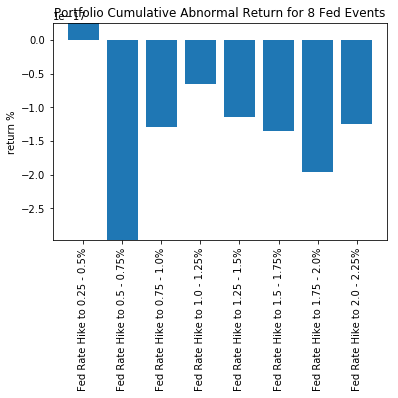

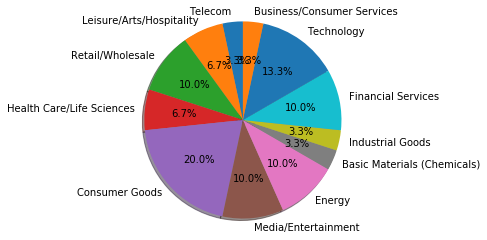

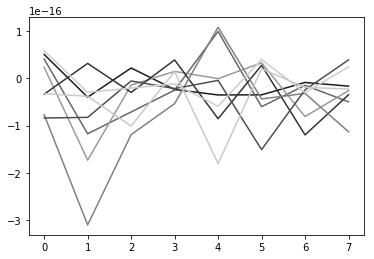

In [13]:
fed.visualization()

## See how the trade war affects the American and  Chinese stocks.

In [21]:
import pandas as pd
import datetime
from datetime import timedelta
import pandas_datareader.data as web
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
class EventStudy_TradeWar():
    def __init__(self,file_path):
        try:
            pd.read_csv(file_path)
        except TypeError:
            return f'Wrong File Type.'
        self.dataframe = pd.DataFrame(pd.read_csv(file_path))
        self.company = self.dataframe['Ticker']
        self.event = self.dataframe['Event']
        self.market = self.dataframe['Market']
        self.industry = self.dataframe['Industry']
        self.year = self.dataframe['Year']
        self.month = self.dataframe['Month']
        self.day = self.dataframe['Day']
        self.dict = {}
        self.reg_result = list()
        self.fed_cumu_ab_ret_per_event = list()
        self.fed_event_list = list()
        self.inds_level_AR = []
        self.indsdict = dict()
        self.reg_result_us = list()
        self.reg_result_china = list()

        for i in range(0,len(self.market)):
            self.dict[self.company[i]] = self.market[i]
        for i in range(0,len(self.industry)):
            self.indsdict[self.company[i]] = self.industry[i]
        eventdate = []
        for i in range(0,len(self.dataframe)):
            eventdate.append(datetime.datetime(self.year[i],self.month[i],self.day[i]))
        self.dataframe['EventDate'] = eventdate
        #suppose there is only one event in a month
        uniquedays = self.dataframe['EventDate'].unique()
        inter_days = []
        for i in range(0,len(uniquedays)-1):
            inter_days.append(int((uniquedays[i+1]-uniquedays[i])/np.timedelta64(1,'D')))
        self.sample_length = min(inter_days)
    
    def reg(self):
        eventdate_set = self.dataframe['EventDate'].unique()
        subdate_cumulative_abnormal_return = pd.DataFrame()
        for date in eventdate_set:
            subevent_df = self.dataframe[self.dataframe.EventDate == date]
            start_date = date - np.timedelta64(self.sample_length, 'D')
            end_date = date + np.timedelta64(self.sample_length, 'D')
            subevent_company_list = subevent_df['Ticker'].unique()
            subevent_us_company_list = list(subevent_df[subevent_df['Country'] == 'U.S.']['Ticker'].unique())
            subevent_china_company_list = list(subevent_df[subevent_df['Country'] == 'China']['Ticker'].unique())
            subevent_cumulative_abnormal_return = pd.DataFrame()
            
            for company in subevent_company_list:
                market = subevent_df[subevent_df.Ticker == company]['Market'].iloc[0]
                price = web.DataReader([company, market],'yahoo', start_date,end_date)
                close_price = price['Close']
                return_rate = close_price.pct_change()
                x = return_rate[company]    
                X = sm.add_constant(x)
                y = return_rate[market]
                model = sm.OLS(y,X,missing='drop')
                result = model.fit()
                (a,b) = result.params

                return_rate['Abnormal_Return'] = return_rate.apply(lambda x: x[market] - a - b * x[company], axis=1)
                subevent_cumulative_abnormal_return[f'{company}'] = return_rate['Abnormal_Return'].cumsum()[1:]
            company_name = list(subevent_cumulative_abnormal_return)
            industry_name = [self.indsdict[i] for i in company_name]
            trans_subevent_cumulative_abnormal_return =subevent_cumulative_abnormal_return.T
            trans_subevent_cumulative_abnormal_return['Industry'] = industry_name
            inds_level_AR = trans_subevent_cumulative_abnormal_return.groupby('Industry').sum()
            inds_level_AR = inds_level_AR.iloc[0:,-1]
            self.inds_level_AR.append(inds_level_AR)
            subevent_cumulative_abnormal_return['Average_CAR'] = subevent_cumulative_abnormal_return.apply(lambda x: x.sum()/(len(subevent_company_list)),axis = 1)
                
                
            subevent_cumulative_abnormal_return_us_company = subevent_cumulative_abnormal_return[subevent_us_company_list]
            subevent_cumulative_abnormal_return_us_company['Average_CAR'] = subevent_cumulative_abnormal_return_us_company.apply(lambda x: x.sum()/(len(subevent_us_company_list)),axis = 1)
                
            subevent_cumulative_abnormal_return_china_company = subevent_cumulative_abnormal_return[subevent_china_company_list]
            subevent_cumulative_abnormal_return_china_company['Average_CAR'] = subevent_cumulative_abnormal_return_china_company.apply(lambda x: x.sum()/(len(subevent_china_company_list)),axis = 1)
            self.reg_result.append(subevent_cumulative_abnormal_return['Average_CAR'])
            self.reg_result_us.append(subevent_cumulative_abnormal_return_us_company['Average_CAR'])
            self.reg_result_china.append(subevent_cumulative_abnormal_return_china_company['Average_CAR'])
        
        self.us_return = sum([i[-1] for i in self.reg_result_us])
        self.china_return = sum([i[-1] for i in self.reg_result_china])
            
    def visualization(self):
       
        plt.bar(list(range(2)),[self.us_return, self.china_return], align='center')
        plt.xticks(list(range(2)), ['U.S.','China'])
        # plt.xticks(rotation=90)
        plt.title("Cumulative Abnormal Returns for U.S. & China Portfolios")
        plt.ylabel('return %')
        plt.show()
        
        empty_inds = pd.DataFrame()
        for i in range(len(self.inds_level_AR)):
            empty_inds[f'{i}'] = self.inds_level_AR[i].values
        z=empty_inds.T
        color = ['0.1','0.4','0.6','0.2','0.5','0.3','0.79','0.8','0.9']
        x = [i for i in range(len(z))]
        q = self.inds_level_AR[0].index
        for i in range(len(z)):
            plt.plot(x,z[i],color[i],label =q[i])
        plt.show()
        
        COL_NUM = 2
        ROW_NUM = len(self.reg_result)//2+1
        fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(200,200))

        for i in range(len(self.reg_result)):
            ax = axes[int(i/COL_NUM), i%COL_NUM]
            self.reg_result[i].plot(kind='bar', ax=ax)
        
        for i in range(len(self.reg_result)):
            ax = axes[int(i/COL_NUM), i%COL_NUM]
            self.reg_result_china[i].plot(kind='line', ax=ax, c='black',title='China', linewidth=20)
            self.reg_result_us[i].plot(kind='line', ax=ax, c='blue', title='US', linewidth=20)
            ax.set_title(str('event'+str(i)))

In [22]:
trade = EventStudy_TradeWar(trade_path)
trade.reg()

/Users/amber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/amber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


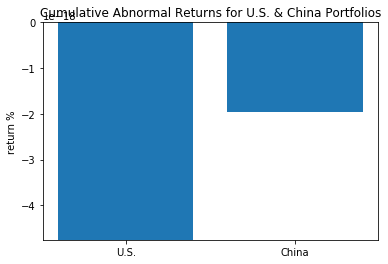

IndexError: list index out of range

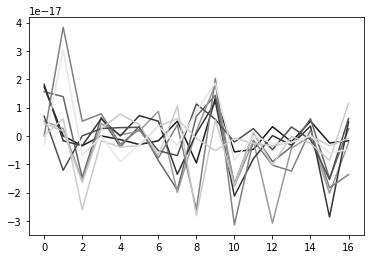

In [23]:
trade.visualization()

<font color = gray size = 10> General Description</font>

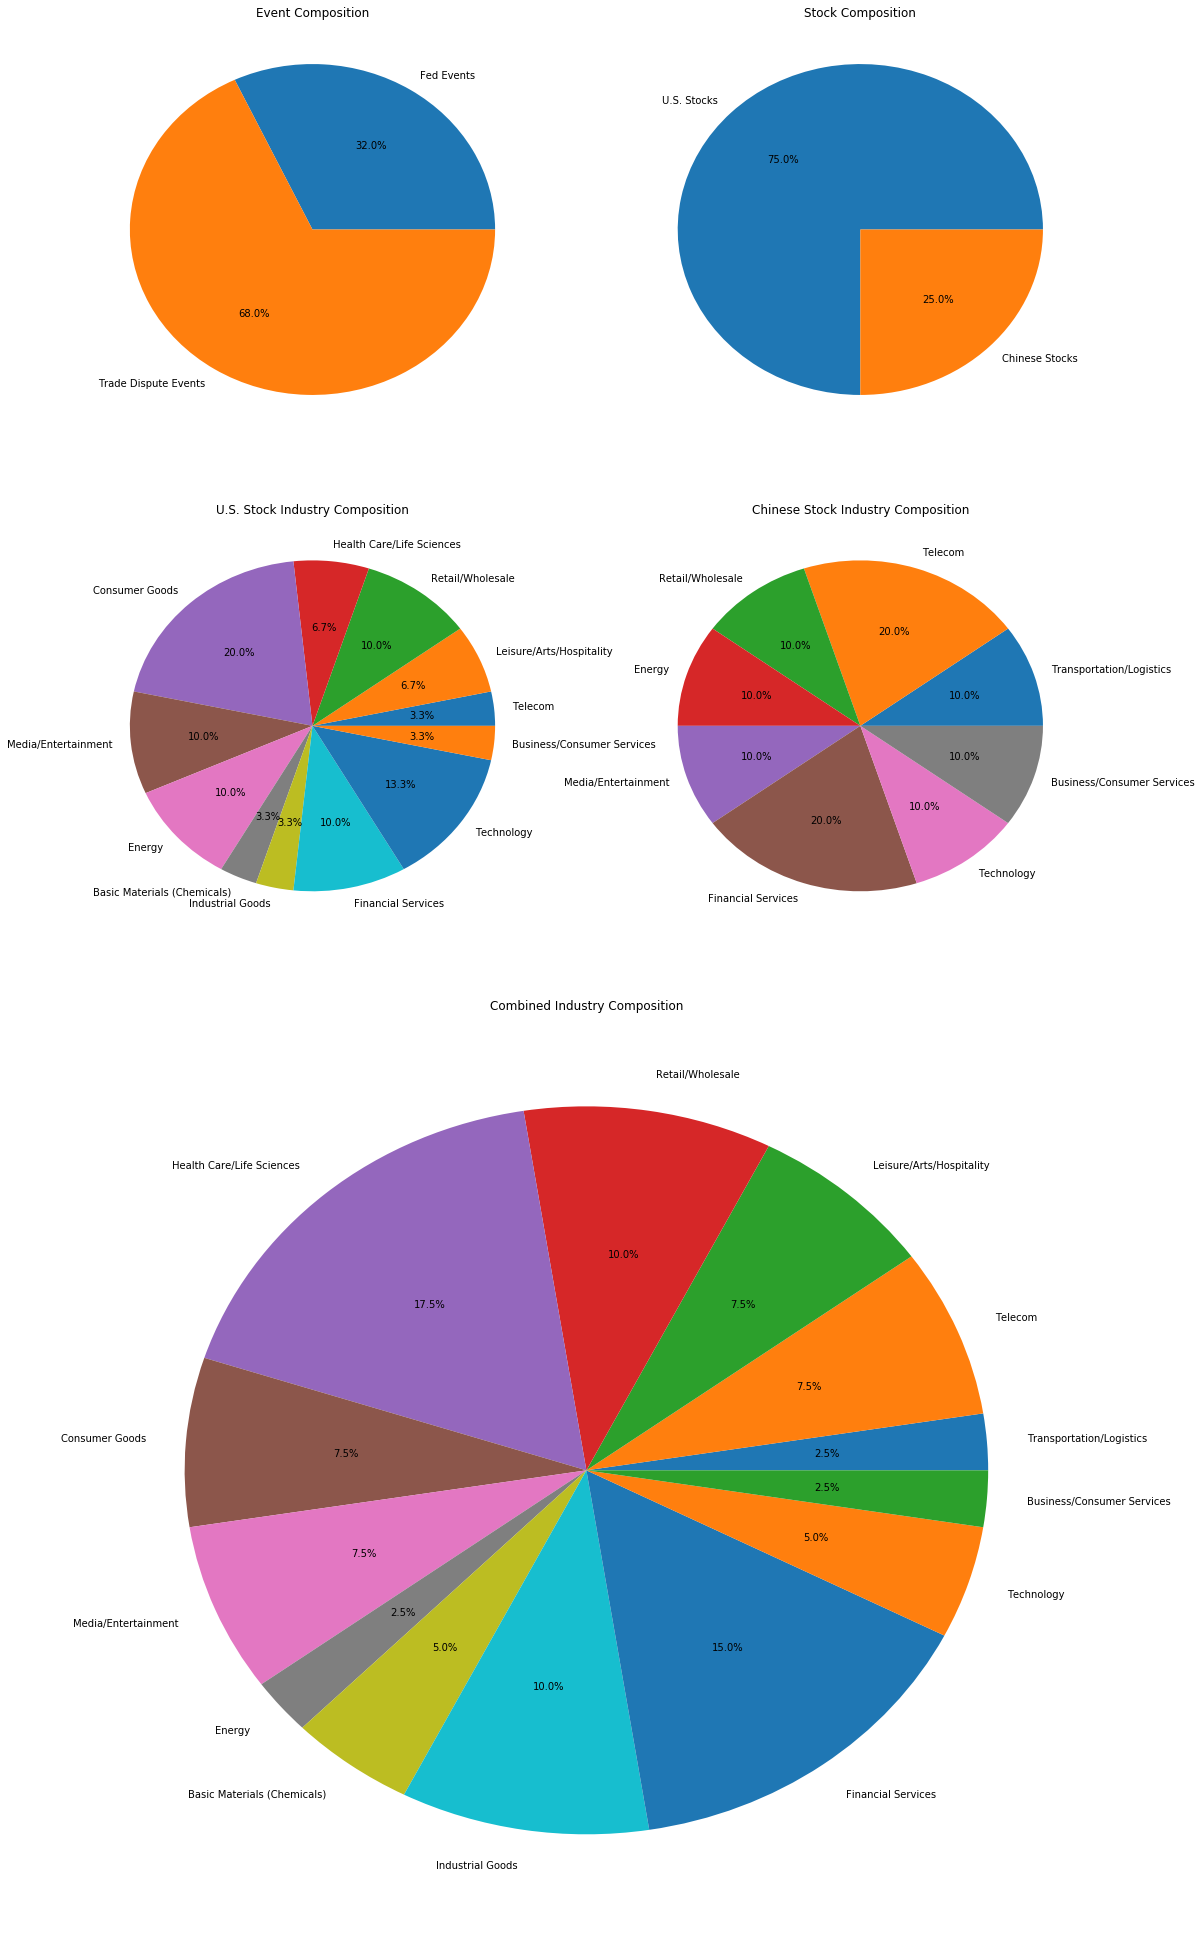

In [24]:
#Visualization
num_fed_events = len(fed.dataframe['EventDate'].unique()) # 8
num_trade_events = len(trade.dataframe['EventDate'].unique()) # 24
event_cat_label = ['Fed Events', 'Trade Dispute Events']# num_trade_events

num_us_stock = len(fed.industry)/num_fed_events #30
num_china_stock = len(trade.industry)/num_trade_events - num_us_stock #10
fed_event_list = list(fed.event[[0 + x*(len(fed.dataframe)-0)/num_fed_events for x in range(num_fed_events)]])
trade_event_list = list(trade.event[[0 + x*(len(trade.dataframe)-0)/num_trade_events for x in range(num_trade_events)]])
# trade_event_list

us_industry_list = list(fed.industry)[0:int(num_us_stock)] #30 with duplicates
us_unique_industry_list = list(set(us_industry_list)) #12 distinct industries
us_unique_industry_count = list(np.unique(us_industry_list, return_counts=True)[1]) # 12 numbers
us_unique_industry_count_pct = [(x*100) / 30 for x in us_unique_industry_count]

china_industry_list = list(trade.industry)[int(num_us_stock):int(num_us_stock+num_china_stock)] #10
china_unique_industry_list = list(set(china_industry_list)) # 8
china_unique_industry_count = list(np.unique(china_industry_list, return_counts=True)[1]) # 8 numbers
china_unique_industry_count_pct = [(x*100) / 30 for x in china_unique_industry_count]

combined_industry_list = list(trade.industry)[0:int(num_us_stock+num_china_stock)] #40 with duplicates
combined_unique_industry_list = list(set(combined_industry_list)) #13 distinct industries
combined_unique_industry_count = list(np.unique(combined_industry_list, return_counts=True)[1])
combined_unique_industry_count_pct = [(x*100) / 30 for x in combined_unique_industry_count]

# 5 plots for event, stock, and industry compositions
import matplotlib.gridspec as gridspec

fig = plt.figure(1)
gridspec.GridSpec(4,2) # 4 rows, 2 columns

# small plot at (0,0)
plt.subplot2grid((4,2), (0,0))
plt.pie([num_fed_events, num_trade_events], labels = event_cat_label, autopct = '%1.1f%%')
plt.title('Event Composition')

# small plot at (0,1)
plt.subplot2grid((4,2), (0,1))
plt.pie([num_us_stock, num_china_stock], labels = ['U.S. Stocks', 'Chinese Stocks'], autopct = '%1.1f%%')
plt.title('Stock Composition')

# small plot at (1,0)
plt.subplot2grid((4,2), (1,0))
plt.pie(us_unique_industry_count_pct,labels = us_unique_industry_list, autopct = '%1.1f%%')
plt.title('U.S. Stock Industry Composition')

# small plot at (1,1)
plt.subplot2grid((4,2), (1,1))
plt.pie(china_unique_industry_count_pct, labels= china_unique_industry_list, autopct = '%1.1f%%')
plt.title('Chinese Stock Industry Composition')

# large plot at (2,0)
plt.subplot2grid((4,2), (2,0), colspan=2, rowspan=2)
plt.pie(combined_unique_industry_count_pct, labels= combined_unique_industry_list, autopct = '%1.1f%%')
plt.title('Combined Industry Composition')

fig.set_size_inches(w=18,h=35)

plt.show()